In [20]:
import os
import subprocess
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import Row

import re
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover


import shutil
import pandas as pd
import numpy as np

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import matplotlib.pyplot as plt

pd.set_option("max_colwidth", 100)
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

from google.cloud import storage

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
%%time

path = 'gs://msca-bdp-students-bucket/shared_data/kaihayden/final2'

tweets_df = spark.read.parquet(path)

CPU times: user 4.96 ms, sys: 75 µs, total: 5.03 ms
Wall time: 6.34 s


In [3]:
tweets_df.columns

['dt_date',
 'dt_datehour',
 'dt_day',
 'dt_hour',
 'dt_month',
 'dt_year',
 'ext_qt_user_id',
 'ext_rp_user_id',
 'ext_rt_id',
 'ext_rt_user_id',
 'is_original',
 'twt_continent',
 'twt_hashtags',
 'twt_id',
 'twt_importance',
 'twt_likes',
 'twt_quote_count',
 'twt_reply_count',
 'twt_retwt_count',
 'twt_text',
 'usr_desc',
 'usr_followers',
 'usr_id',
 'usr_location',
 'usr_name',
 'usr_tweet_count',
 'usr_verified']

In [22]:
tweets_df_o = tweets_df.filter((col('is_original')==1)&\
                               (col('ext_rp_user_id').isNull())&\
                               (col('ext_rt_id').isNull())&\
                               (col('ext_qt_user_id').isNull()))

In [23]:
tweets_df_o.count()

2648070

In [5]:
tweets_df_recent = tweets_df_o.filter((col('dt_year')==2021) & (col("dt_month")>=11)&(col("dt_day")>=11))

In [6]:
tweets_df_recent.count()

104909

In [7]:
%%time

df_text_raw_full = tweets_df_recent.select(["twt_text"]).withColumnRenamed('twt_text', 'text')

df_text_raw = df_text_raw_full.withColumn("index", monotonically_increasing_id())

df_text_raw = df_text_raw.orderBy(desc("index")).drop("index").limit(25000)

CPU times: user 1.24 ms, sys: 4.27 ms, total: 5.5 ms
Wall time: 97.3 ms


In [8]:
text = df_text_raw.rdd.map(lambda x : x['text'])

StopWords = stopwords.words("english")

tokens = text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if x.isalnum()])\
    .map( lambda word: [x for x in word if x not in StopWords])\
    .map( lambda word: [x for x in word if len(x) >= 3] )\
    .map( lambda word: [x for x in word if not x.startswith('http')])\
    .zipWithIndex()

In [9]:
%%time

row = Row('text')
df_text = text.map(row).zipWithIndex().toDF(['text','id'])

CPU times: user 24.7 ms, sys: 849 µs, total: 25.5 ms
Wall time: 11.9 s


In [10]:
df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])
df_tokens = df_tokens.where(col('list_of_words').getItem(0).isNotNull())

In [11]:
%%time
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1)
df_vectorize = vectorize.fit(df_tokens).transform(df_tokens)

CPU times: user 18.5 ms, sys: 4.47 ms, total: 22.9 ms
Wall time: 4.86 s


In [12]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=4)
model = mh.fit(df_vectorize)
df_hashed = mh.fit(df_vectorize).transform(df_vectorize)
df_hashed_text = df_text.join(df_hashed, "id", how = 'left')

In [22]:
jaccard_distance_2 = 0.2
jaccard_distance_4 = 0.4
jaccard_distance_6 = 0.6

df_dups_text_2 = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance_2).filter("datasetA.id < datasetB.id").select(
                 col("distCol"),
                 col("datasetA.id").alias("id_A"),
                 col("datasetB.id").alias("id_B"),
                 col('datasetA.text').alias('text_A'),
                 col('datasetB.text').alias('text_B'),
                 )

df_dups_text_4 = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance_4).filter("datasetA.id < datasetB.id").select(
                 col("distCol"),
                 col("datasetA.id").alias("id_A"),
                 col("datasetB.id").alias("id_B"),
                 col('datasetA.text').alias('text_A'),
                 col('datasetB.text').alias('text_B'),
                 )

df_dups_text_6 = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance_6).filter("datasetA.id < datasetB.id").select(
                 col("distCol"),
                 col("datasetA.id").alias("id_A"),
                 col("datasetB.id").alias("id_B"),
                 col('datasetA.text').alias('text_A'),
                 col('datasetB.text').alias('text_B'),
                 )

In [14]:
%%time

records = df_hashed_text.count()

CPU times: user 23.3 ms, sys: 12.7 ms, total: 36.1 ms
Wall time: 7.98 s


In [ ]:
%%time
dups_2 = df_dups_text_2.select('id_A').distinct().count()

CPU times: user 192 ms, sys: 63.5 ms, total: 256 ms
Wall time: 9min 28s


In [ ]:
%%time
dups_4 = df_dups_text_4.select('id_A').distinct().count()

CPU times: user 177 ms, sys: 72 ms, total: 249 ms
Wall time: 9min 34s


In [ ]:
%%time
dups_6 = df_dups_text_6.select('id_A').distinct().count()

CPU times: user 180 ms, sys: 76 ms, total: 256 ms
Wall time: 9min 42s


In [ ]:
uniques_2 = records - dups_2
uniques_4 = records - dups_4
uniques_6 = records - dups_6

print ('Total records: ', records)
print('\n')
print ('Duplicate Tweets based on {', jaccard_distance_2, '} jaccard distance: ', dups_2)
print ('Unique Tweets based on {', jaccard_distance_2, '} jaccard distance: ', uniques_2)
print('\n')
print ('Duplicate Tweets based on {', jaccard_distance_4, '} jaccard distance: ', dups_4)
print ('Unique Tweets based on {', jaccard_distance_4, '} jaccard distance: ', uniques_4)
print('\n')
print ('Duplicate Tweets based on {', jaccard_distance_6, '} jaccard distance: ', dups_6)
print ('Unique Tweets based on {', jaccard_distance_6, '} jaccard distance: ', uniques_6)

Total records:  25000


Duplicate Tweets based on { 0.2 } jaccard distance:  4881
Unique Tweets based on { 0.2 } jaccard distance:  20119


Duplicate Tweets based on { 0.4 } jaccard distance:  6050
Unique Tweets based on { 0.4 } jaccard distance:  18950


Duplicate Tweets based on { 0.6 } jaccard distance:  7888
Unique Tweets based on { 0.6 } jaccard distance:  17112


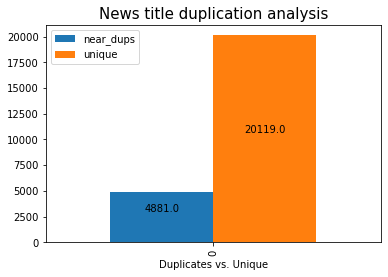

In [25]:
dups_df_2 = pd.DataFrame.from_dict({'near_dups': [dups_2], 'unique': [uniques_2]})

ax=dups_df_2.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('News title duplication analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

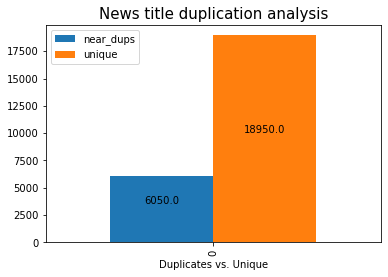

In [26]:
dups_df_4 = pd.DataFrame.from_dict({'near_dups': [dups_4], 'unique': [uniques_4]})

ax=dups_df_4.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('News title duplication analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

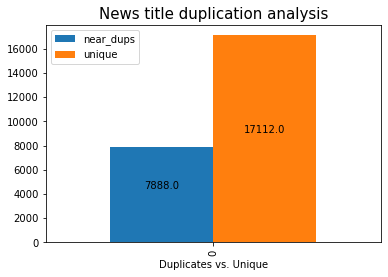

In [27]:
dups_df_6 = pd.DataFrame.from_dict({'near_dups': [dups_6], 'unique': [uniques_6]})

ax=dups_df_6.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('News title duplication analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

Original Tweets: 2,739,456

Near Duplicate Tweets:

Unique Tweets:


In [28]:
%%time
df_dups_20_id = df_dups_text_2.select(col('id_A').alias('id_20_A'), col('id_B').alias('id_20_B'))
df_dups_40_id = df_dups_text_4.select(col('id_A').alias('id_40_A'), col('id_B').alias('id_40_B'))
df_dups_60_id = df_dups_text_6.select(col('text_A'), col('text_B'), col('id_A').alias('id_60_A'), col('id_B').alias('id_60_B'))

CPU times: user 6.72 ms, sys: 3.85 ms, total: 10.6 ms
Wall time: 54.6 ms


In [29]:
%%time
dups_combined = df_dups_60_id.join(df_dups_40_id, on=((df_dups_60_id.id_60_A == df_dups_40_id.id_40_A) & \
                                                      (df_dups_60_id.id_60_B == df_dups_40_id.id_40_B)), how="left_outer")\
                             .join(df_dups_20_id, on=((df_dups_60_id.id_60_A == df_dups_20_id.id_20_A) & \
                                                      (df_dups_60_id.id_60_B == df_dups_20_id.id_20_B)), how="left_outer")

CPU times: user 5.6 ms, sys: 1.14 ms, total: 6.74 ms
Wall time: 48.4 ms


In [31]:
%%time
dups_combined = dups_combined.\
                withColumn("threshold_20",\
                           when(col("id_20_A").isNotNull(), "Duplicate").
                           otherwise("Non-Dup")).\
                withColumn("threshold_40",\
                           when(col("id_40_A").isNotNull(), "Duplicate").
                           otherwise("Non-Dup")).\
                withColumn("threshold_60",\
                           when(col("id_60_A").isNotNull(), "Duplicate").
                           otherwise("Non-Dup")).\
                drop('id_20_A', 'id_20_B', 'id_40_A', 'id_40_B', 'id_60_A', 'id_60_B')

CPU times: user 9.06 ms, sys: 136 µs, total: 9.2 ms
Wall time: 68.9 ms


In [32]:
%%time
dups_combined_sample = dups_combined.filter(("threshold_20 == 'Duplicate'")).sample(False, 0.1, 12345).limit(5).\
                       union\
                       (dups_combined.filter(("threshold_20 == 'Non-Dup' and threshold_40 == 'Duplicate'")).sample(False, 0.1, 12345).limit(5)).\
                       union\
                       (dups_combined.filter(("threshold_40 == 'Non-Dup'")).sample(False, 0.1, 12345).limit(5)).\
                       orderBy('threshold_20', 'threshold_40', 'threshold_60')

CPU times: user 6.52 ms, sys: 4.68 ms, total: 11.2 ms
Wall time: 158 ms


In [ ]:
%%time
dups_combined_sample.show(15, False, vertical=True)

-RECORD 0--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 text_A       | [germany’s fourth covid wave: ‘a pandemic of the unvaccinated’ https://t.co/jjscjvf07b]                                                                            
 text_B       | [germany’s fourth covid wave: ‘a pandemic of the unvaccinated’ https://t.co/yj6ysmwini]                                                                            
 threshold_20 | Duplicate                                                                                                                                                          
 threshold_40 | Duplicate                                                                                                                                                          
 threshold_60 | Duplicate                                                                           

In [4]:
dups_df_2 = pd.DataFrame.from_dict({'near_dups': [4881], 'unique': [20119]})
dups_df_4 = pd.DataFrame.from_dict({'near_dups': [6050], 'unique': [18950]})
dups_df_6 = pd.DataFrame.from_dict({'near_dups': [7888], 'unique': [17112]})


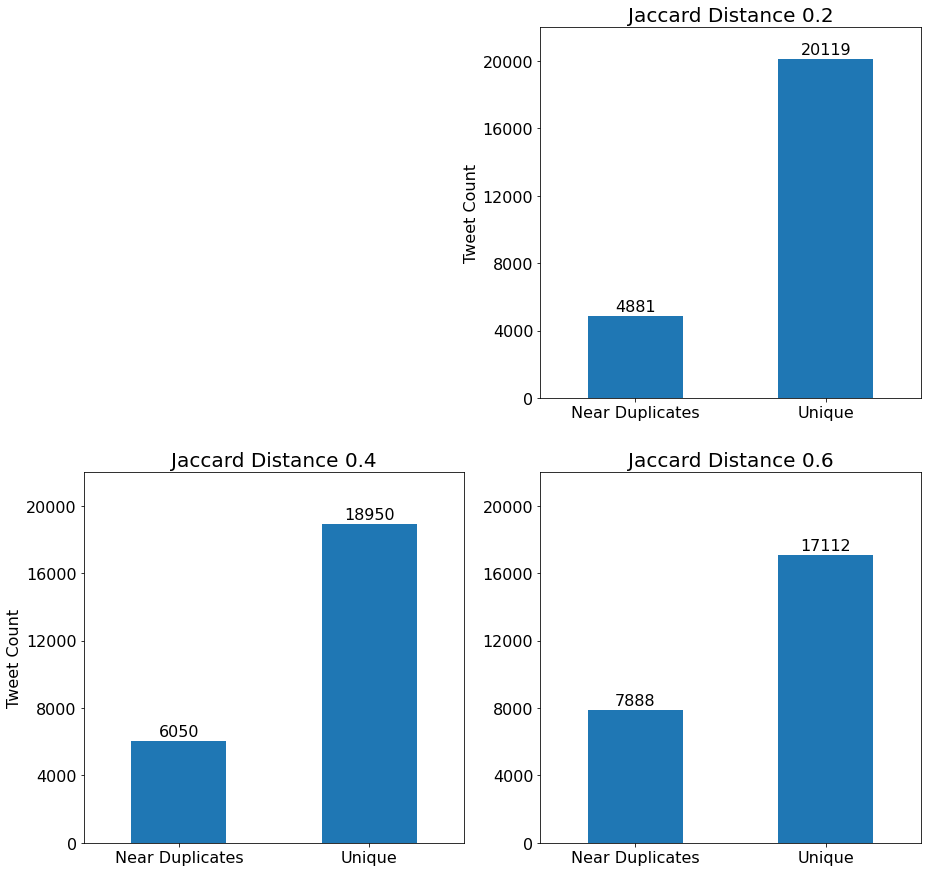

In [19]:
fig, ax = plt.subplots(2,2,figsize=(15,15))

ax[0,0].axis('off')

dups_df_2.transpose().plot.bar(ax=ax[0,1])
dups_df_4.transpose().plot.bar(ax=ax[1,0])
dups_df_6.transpose().plot.bar(ax=ax[1,1])

ax[0,1].set_xticklabels(['Near Duplicates','Unique'])
ax[1,0].set_xticklabels(['Near Duplicates','Unique'])
ax[1,1].set_xticklabels(['Near Duplicates','Unique'])

ax[0,1].set_ylim(0,22000)
ax[1,0].set_ylim(0,22000)
ax[1,1].set_ylim(0,22000)
ax[0,1].set_yticks(np.arange(0, 22000, 4000))
ax[1,0].set_yticks(np.arange(0, 22000, 4000))
ax[1,1].set_yticks(np.arange(0, 22000, 4000))

ax[0,1].tick_params(axis='both', which='major', labelsize=16)
ax[1,0].tick_params(axis='both', which='major', labelsize=16)
ax[1,1].tick_params(axis='both', which='major', labelsize=16)

ax[0,1].tick_params(axis='x', rotation=0)
ax[1,0].tick_params(axis='x', rotation=0)
ax[1,1].tick_params(axis='x', rotation=0)

ax[0,1].set_ylabel("Tweet Count", fontsize=16)
ax[1,0].set_ylabel("Tweet Count", fontsize=16)

ax[0,1].set_title("Jaccard Distance 0.2", fontsize=20)
ax[1,0].set_title("Jaccard Distance 0.4", fontsize=20)
ax[1,1].set_title("Jaccard Distance 0.6", fontsize=20)

ax[0,1].legend().set_visible(False)
ax[1,0].legend().set_visible(False)
ax[1,1].legend().set_visible(False)

for p in ax[0,1].patches:
       ax[0,1].annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', fontsize=16,
                   xytext = (0, 9), 
                   textcoords = 'offset points') 
for p in ax[1,0].patches:
       ax[1,0].annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', fontsize=16,
                   xytext = (0, 9), 
                   textcoords = 'offset points') 
for p in ax[1,1].patches:
       ax[1,1].annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', fontsize=16,
                   xytext = (0, 9), 
                   textcoords = 'offset points') 
plt.savefig('./graph5.png',bbox_inches='tight')
plt.show()